## Face Detection using PCA (Eigenfaces)

This is an implementation of the paper "Eigenfaces for Recognition"<sup>[1]</sup> by Turk and Pentland.
The process involves 3 major steps:
1. Creating a suitable dataset.
2. Manipulating image dimensions to get Face Space.
3. Using Face weights obtained, try to recognize the test image

### Step I: Dataset and prerequisites
#### Importing Libraries
1. Numpy is used as a standard contaier datatype for processing, 
2. OpenCV for limited use of reading images,
3. os for file handling operations
4. Random for random number generation
5. Sklearn for metrics only
6. Matplotlib for plotting

In [1]:
import numpy as np
import cv2
import os
import random
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from matplotlib import pyplot as plt

#### Loading Dataset
Here, we are using the AT & T Dataset. This is of the size 92x112, but since we don't know what our test images may be, we convert all images to m=256 x n=256 (from [1]) and append to the dataset. 
We are going for 70-30 split. To change percentage, change value of train_count

In [2]:
faces_dir = "./orl_faces/"
faces_count = len(os.listdir(faces_dir)) -1

train_count = 7
test_count =  len(os.listdir(faces_dir)[0]) - train_count

l = train_count * faces_count
m = 256         
n = 256 
mn = m * n 

print ('Creating Dataset')
print ('Loading Data...\nClass, Train, Test')


training_ids = [] 
test_ids = []
A = np.zeros(shape=(mn,l), dtype='float64')
avg = np.zeros(shape=(m,n))

cur_img = 0

for face_id in xrange(1, faces_count + 1):
    
    sample_training_ids = random.sample(range(1, 11), train_count)   
    sample_test_ids = [i for i in range(1,11) if i not in sample_training_ids]
    training_ids.append(sample_training_ids)                             
    test_ids.append(sample_test_ids)
    
    print(face_id,sample_training_ids, sample_test_ids)
    for training_id in sample_training_ids:
        path_to_img = os.path.join(faces_dir,
                's' + str(face_id), str(training_id) + '.pgm')         

        img = cv2.imread(path_to_img, 0)                                
        img = cv2.resize(img,(m,n))
        avg += img
        
        img_col = np.array(img, dtype='float64').flatten()             

        A[:, cur_img] = img_col[:]                                      
        cur_img += 1
        
print "Dataset loaded and processed"

Creating Dataset
Loading Data...
Class, Train, Test
(1, [10, 5, 2, 1, 7, 8, 4], [3, 6, 9])
(2, [5, 10, 4, 6, 8, 9, 7], [1, 2, 3])
(3, [5, 3, 4, 8, 7, 1, 2], [6, 9, 10])
(4, [5, 6, 4, 1, 2, 9, 7], [3, 8, 10])
(5, [2, 3, 7, 4, 6, 5, 9], [1, 8, 10])
(6, [8, 10, 4, 2, 6, 7, 5], [1, 3, 9])
(7, [6, 10, 1, 4, 9, 2, 5], [3, 7, 8])
(8, [6, 8, 10, 1, 7, 5, 4], [2, 3, 9])
(9, [6, 8, 7, 3, 10, 9, 5], [1, 2, 4])
(10, [7, 1, 8, 6, 3, 2, 5], [4, 9, 10])
(11, [7, 2, 9, 10, 6, 3, 1], [4, 5, 8])
(12, [8, 6, 1, 4, 2, 10, 5], [3, 7, 9])
(13, [10, 1, 8, 6, 4, 2, 9], [3, 5, 7])
(14, [2, 6, 4, 3, 1, 10, 8], [5, 7, 9])
(15, [3, 9, 5, 2, 7, 10, 6], [1, 4, 8])
(16, [9, 6, 1, 5, 7, 2, 4], [3, 8, 10])
(17, [1, 2, 6, 5, 10, 4, 9], [3, 7, 8])
(18, [8, 4, 10, 2, 3, 1, 6], [5, 7, 9])
(19, [4, 1, 3, 9, 7, 8, 5], [2, 6, 10])
(20, [7, 9, 10, 3, 5, 8, 4], [1, 2, 6])
(21, [7, 3, 10, 9, 2, 6, 5], [1, 4, 8])
(22, [6, 5, 9, 10, 7, 1, 8], [2, 3, 4])
(23, [8, 4, 3, 10, 6, 9, 7], [1, 2, 5])
(24, [10, 2, 3, 6, 8, 5, 9], [1, 4, 7

In [3]:
avg_col = np.sum(A, axis=1) / l 

for j in xrange(0, l):
    A[:, j] -= avg_col[:] 

### Average Image
Average generated only over test images

In [4]:
avg /= faces_count
avg = np.uint8(avg)
cv2.imshow("Average", avg)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite("./Average.jpg", avg)

True

### PCA of Training Data

Based on the fact that A<sup>T</sup>A return top M values of the same as AA<sup>T</sup> matrix, we find C

In [5]:
C = np.matmul(A.T,A)
C /= l    

### Training

Training is done by finding relevant eigenvalues and choosing the number based on energy fraction of the signal (as compared to randomly choosing no. of dimensions)

In [6]:
#energy = 0.85
def train(energy):
    evalues, evectors = np.linalg.eig(C)                          # eigenvectors/values of the covariance matrix
    sort_indices = evalues.argsort()[::-1]                             # getting their correct order - decreasing
    evalues = evalues[sort_indices]                               # puttin the evalues in that order
    evectors = evectors[sort_indices]                             # same for the evectors

    evalues_sum = sum(evalues[:])                                      # include only the first k evectors/values so
    evalues_count = 0                                                       # that they include approx. 85% of the energy
    evalues_energy = 0.0
    for evalue in evalues:
        evalues_count += 1
        evalues_energy += evalue / evalues_sum

        if evalues_energy >= energy:
            break

    evalues = evalues[0:evalues_count]                           
    evectors = evectors[0:evalues_count]

    evectors = evectors.transpose()                               
    evectors = np.matmul(A,evectors)                                 
    norms = np.linalg.norm(evectors, axis=0)                        
    evectors = evectors / norms                                

    #print 'Weights Calculated'
    return evectors

The trained eigenvectors for given energy are obtained. For example, here we have for 0.9; based on which Weight matrix is found as linear combination weights of all training images

In [7]:
evectors = train(0.9)
W = np.matmul(evectors.T,A)

This means that out of 400 features found in C, 90% of the relevant features are contributed by top most ~78 features (based on eigen values)

#### Face Detection using HaarCascades

In [8]:
def Detect(gray):
    from cv2.data import haarcascades
    face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
#     gray = cv2.imread(path,0)
    faces = face_cascade.detectMultiScale(gray, 1.3, 7)
    #print('Faces found: ', len(faces))
    return faces

### Recognition

We start with building classify() function that classifies based on the Weights and their respective distances from projection of images on face space.
Value of threshold is set experimentally

In [9]:
def classify(path_to_img="",im=[]):
    if path_to_img!="":
        img = cv2.imread(path_to_img, 0)
    else:
        img = im
    img = cv2.resize(img,(m,n))
    img_col = np.array(img, dtype='float64').flatten()
    img_col -= avg_col  
    img_col = np.reshape(img_col, (mn, 1)) 

    S = np.matmul(evectors.transpose(),img_col)
    W = np.matmul(evectors.T,A)

    diff = W - S
    norms = np.linalg.norm(diff, axis=0)

    closest_face_id = np.argmin(norms)
    thresh = 10000
    print norms[closest_face_id]
    if norms[closest_face_id]<=thresh:
        return (closest_face_id / train_count) + 1 
    else:
        print("No Faces Matching for dist", norms[closest_face_id])
        return 0

### Testing
We test based on the validation set created from the database. This is to obtain a general classification report. Further we test for images not having any faces (here made out of a random generator). Norms are printed

First we Test for Non Matching Faces after Detection

In [10]:
img = cv2.imread("./Baby.png",0)
faces = Detect(img)
if len(faces)>0:
    for (x,y,w,h) in faces:
        print(classify(im=img[x:x+w,y:y+h]))


13070.255777195729
('No Faces Matching for dist', 13070.255777195729)
0


In [11]:
def Test():
    y_true = []
    y_pred = []
    for face_id in range(len(test_ids)):
        for im in test_ids[face_id]:
            path_to_img = "./orl_faces/s"+str(face_id+1)+"/"+str(im)+".pgm"
            y_pred.append(classify(path_to_img))
            y_true.append(face_id+1)
    return y_pred, y_true

y_pred, y_true = Test()

8099.506857770488
10420.610650009932
('No Faces Matching for dist', 10420.610650009932)
9054.311331623778
3833.187159056037
2123.861689978975
2014.6365297574416
5148.052093977828
7542.534612218251
7328.162901863186
5701.942886998628
6218.917258307448
5207.6675052309365
2135.873224176164
2728.166123656698
5496.021600234257
3239.37280511226
4786.906566157219
4972.255903129446
3954.9032853440235
3827.0657747810233
6170.615546621339
4160.320736004029
3463.725976694103
7265.409107821813
3439.4952291842537
4096.973300371579
4927.547899671674
4289.211456709061
10184.18536223412
('No Faces Matching for dist', 10184.18536223412)
13166.310280082036
('No Faces Matching for dist', 13166.310280082036)
10980.317383017138
('No Faces Matching for dist', 10980.317383017138)
10669.966676204016
('No Faces Matching for dist', 10669.966676204016)
6820.526160964587
5400.582757965153
3982.6315055863347
3024.427947532804
3395.5115578395285
1592.187423819233
1231.708783525347
5103.309738772134
3909.95823584555

In [12]:
print(confusion_matrix(y_pred,y_true))

[[0 1 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 3]]


In [13]:
print(classification_report(y_true,y_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       1.00      0.67      0.80         3
          2       1.00      1.00      1.00         3
          3       1.00      0.67      0.80         3
          4       0.75      1.00      0.86         3
          5       0.60      1.00      0.75         3
          6       1.00      1.00      1.00         3
          7       1.00      1.00      1.00         3
          8       1.00      1.00      1.00         3
          9       1.00      1.00      1.00         3
         10       1.00      0.33      0.50         3
         11       1.00      0.33      0.50         3
         12       1.00      1.00      1.00         3
         13       0.75      1.00      0.86         3
         14       1.00      1.00      1.00         3
         15       0.75      1.00      0.86         3
         16       1.00      1.00      1.00         3
         17       1.00      1.00      1.00   

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Analysis
We analyse accuracy as well as time taken for various signal enegry fractions (PCA)

In [14]:
import time
acc = []
dur = []
lc = 5
for i in range(lc):
    t0 = time.time()
    evectors = train(i*1.0/lc)
    t1 = time.time()
    W = np.matmul(evectors.T,A)
    y_pred, y_true = Test()
    acc.append(accuracy_score(y_true, y_pred))
    dur.append(t1-t0)

15.274432311083729
3.782879900543776
62.86688133539792
1.2711189709339124
11.406000604055862
32.60870464121513
3.9153572895465913
0.8606449976141448
17.20949790772147
16.515349108451446
5.321651086909128
10.563038954036983
4.571844643380018
1.1585177026240672
9.885847956893599
1.613959944911585
27.33767973090744
4.6432311032158395
3.138169828023365
49.82726837764187
30.01371830917447
2.41474718219888
4.060748553210942
18.121664182394767
63.60988105902453
65.08987205477374
33.12429425543132
5.352007724767418
5.907418634725218
0.3495359068995185
2.3866368522030825
25.833119563309992
33.9808217210973
8.749905056471107
9.23585318903497
15.502806674170188
7.1013692469488205
2.0467573315227128
6.070366502864545
10.279010331111976
4.030885198787473
8.828419380477499
9.674068441049258
1.0379774564577247
11.437980603332463
10.797123743602242
17.55974988969774
4.408491015687559
7.3252849517159575
9.990386025835733
7.756303092960252
4.8093176090008
10.579983159320818
9.946964123314501
25.46725290

1447.3678729761875
1049.7629869837117
1468.5627464525544
1527.43046613857
1540.2410160487698
1778.1910576304906
2806.385835924203
2000.5815101166659
1551.1738167587637
296.98834753906954
509.95217726753623
1712.6878583427456
1173.7557536459262
2037.4893418251897
1948.7884868075084
2333.8438332265355
2077.24699414473
1722.9838523901353
1575.5272537903772
1043.8744102320052
1632.6879798580433
809.8475236870784
587.9319242049113
1669.6071439744105
991.32166242991
2495.7114103358017
3064.0586634157885
1340.537934299094
2052.7741609508394
1219.8416410832099
1255.7897489179638
5381.313051763698
7062.063464062
5330.455056397593
2376.647009829714
1445.041009973024
1463.2564101259827
3717.9331365962335
4845.309284535487
5211.768982562765
3205.4900744296683
3642.456285718514
3566.647159011866
1346.245285907428
1855.3449038984375
3620.9292388414187
2421.7372190530623
3813.8900142664284
3685.4261987364525
2795.545838403526
2153.7784896981075
4230.395365688661
2598.571473255755
2044.309105925034
52

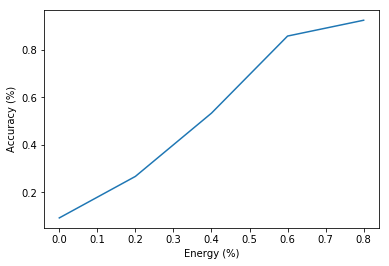

In [15]:
plt.plot(np.array(range(lc))*1.0/lc,acc)
plt.xlabel("Energy (%)")
plt.ylabel("Accuracy (%)")
#plt.show()
plt.savefig("./Acc-Energy.jpg")

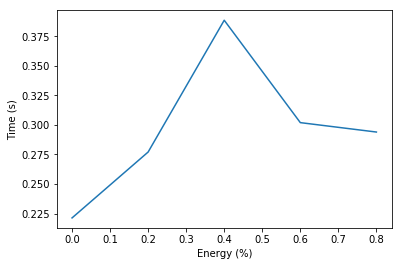

In [16]:
plt.plot(np.array(range(lc))*1.0/lc, dur)
plt.xlabel("Energy (%)")
plt.ylabel("Time (s)")
#plt.show()
plt.savefig("./Time-Energy.jpg")

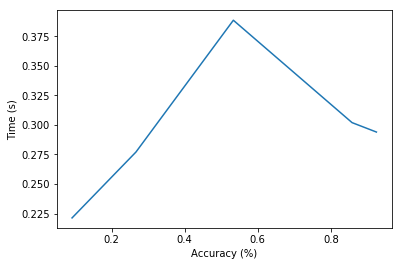

In [17]:
plt.plot(acc, dur)
plt.xlabel("Accuracy (%)")
plt.ylabel("Time (s)")
#plt.show()
plt.savefig("./Acc-Time.jpg")

### References:
1. Eigenfaces for Recognition, by Turk and Pentland
2. Inspired from https://github.com/agyorev/Eigenfaces
3. http://www.vision.jhu.edu/teaching/vision08/Handouts/case_study_pca1.pdf
4. https://onionesquereality.wordpress.com/2009/02/11/face-recognition-using-eigenfaces-and-distance-classifiers-a-tutorial/
